In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import os
import torchvision.utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from matplotlib import image
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def image_preprocess(path, train_split, val_split, batch_size, inp_size):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  transform=transforms.Compose([transforms.Resize(inp_size[0]), transforms.RandomVerticalFlip(), 
                                transforms.CenterCrop(inp_size[0]), transforms.ToTensor(), normalize])
  data = datasets.ImageFolder(root=path, transform=transform)
  test_split = round((1-train_split-val_split), 2)
  data_length = len(data)

  print(data_length, int(train_split*data_length),int(val_split*data_length), int(test_split*data_length))

  train_size = int(train_split*data_length)
  val_size = int(val_split*data_length)
  test_size = data_length - val_size - train_size

# The no. of images in each split of train, val and test
  train_data, val_data, test_data = td.random_split(data, [train_size, val_size, 
                                                    test_size])

  # Create the data loaders
  train_loader = td.DataLoader(train_data,  batch_size=batch_size, 
                               shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  val_loader = td.DataLoader(val_data,  batch_size=batch_size, 
                             shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  test_loader = td.DataLoader(test_data, batch_size=batch_size, 
                              shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  
  return train_loader, val_loader, test_loader

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, lossFunc, epochs=15):
    start = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))

    best_model_weights = model.state_dict()
    best_accuracy = 0

    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(1,epochs+1):

      for i, train_batch in enumerate(train_loader):
        images, labels, model = train_batch[0].to(device), train_batch[1].to(device), model.to(device)

        outputs = model(images)
        loss = lossFunc(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        for j, val_batch in enumerate(val_loader):
          images_, labels_ = val_batch[0].to(device), val_batch[1].to(device)
          outputs_ = model(images_)
          loss_ = lossFunc(outputs_, labels_)
          total_ = labels_.size(0)
          _,predicted_ = torch.max(outputs_.data, 1)
          correct_ = (predicted_ == labels_).sum().item()

        train_loss = loss.item()
        train_accuracy = (correct / total) * 100
        train_accuracy_list.append(train_accuracy)
        val_loss = loss_.item()
        val_accuracy = (correct_ / total_) * 100
        val_accuracy_list.append(val_accuracy)

        if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          best_model_weights = model.state_dict()

        print("Epoch [{}/{}], Train_Loss: {:.4f}, Train_Accuracy: {:.2f}%  Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%"
                .format(epoch, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
      # checkpoint_resNet = {
      # "model": resNet,
      # "train_accuracy_list": train_accuracy_list,
      # "val_accuracy_list": val_accuracy_list,
      # "state_dict": resNet.state_dict()
      # }

      # torch.save(checkpoint_resNet, "/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/resNet50.pth")
    end = time.time()    
    print("######## Training Finished in {} seconds ###########".format(end-start))
    model.load_state_dict(best_model_weights)
    return model, best_model_weights, train_accuracy_list, val_accuracy_list
    

In [ ]:
def evaluate_accuracy(model, test_loader):
  # total, (correct / total) * 100
  model.eval() 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model2 = model.to(device)
  with torch.no_grad(): 
      correct = 0
      total = 0
      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model2(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))
      
  return 

# Evaluation Metrics

## Dataset-1

### ResNet50

In [ ]:
path="/content/drive/MyDrive/AI Final Project/23Class"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224,224))

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet_tl_23.pth")

In [ ]:
resNet.keys()

In [ ]:
train_accuracy = sum(resNet['training_accuracy_list']) / len(resNet['training_accuracy_list'])
train_accuracy

In [ ]:
val_accuracy = sum(resNet['val_accuracy_list']) / len(resNet['val_accuracy_list'])
val_accuracy

In [ ]:
model = resnet50()
num_ftrs = model.fc.in_features
path = "/content/drive/MyDrive/AI Final Project/23Class"
classes = os.listdir(path+"/")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
model.load_state_dict(resNet['state_dict'])
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()



In [ ]:
evaluate_accuracy(model, test_loader)

In [ ]:
import numpy as np

In [ ]:
def visualization(model, test_loader, path):
    
    y_true = []
    y_pred = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for data in test_loader:
      images,labels=data[0].to(device),data[1]
      y_true.extend(labels.numpy())
      outputs=model(images)
      _, predicted = torch.max(outputs, 1)
      y_pred.extend(predicted.cpu().numpy())

    cf_matrix = confusion_matrix(y_true, y_pred)
    class_names = []
    for class_name in os.listdir(path):
        class_names.append(class_name)
    print(classification_report(y_true, y_pred, target_names=tuple(class_names)))  
    
    # Create pandas dataframe
    dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
    
    plt.title("Confusion Matrix"), plt.tight_layout()
    
    plt.ylabel("True Class"), 
    plt.xlabel("Predicted Class")
    plt.show()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/23Class")

### DenseNet

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/denseNet_23.pth")

In [ ]:
train_accuracy = sum(denseNet['train_accuracy_list']) / len(denseNet['train_accuracy_list'])
train_accuracy

In [ ]:
val_accuracy = sum(denseNet['val_accuracy_list']) / len(denseNet['val_accuracy_list'])
val_accuracy

In [ ]:
Dense_net = torchvision.models.densenet121()
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 23)
Dense_net.load_state_dict(denseNet['state_dict'])

optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(Dense_net, test_loader)

In [ ]:
visualization(Dense_net, test_loader, "/content/drive/MyDrive/AI Final Project/23Class")

### VGG

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg_23.pth")

In [ ]:
train_accuracy = sum(vgg['training_accuracy_list']) / len(vgg['training_accuracy_list'])
train_accuracy

In [ ]:
val_accuracy = sum(vgg['val_accuracy_list']) / len(vgg['val_accuracy_list'])
val_accuracy

In [ ]:
model = torchvision.models.vgg16()
num_features =model.classifier[6].in_features
features = list(model.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, 23)]) 
model.classifier = nn.Sequential(*features)
model.load_state_dict(vgg['state_dict'])
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(model, test_loader)

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/23Class")

### Dataset-2

In [ ]:
path="/content/drive/MyDrive/AI Final Project/eightClass"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224,224))

4000 2800 400 800


### ResNet

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet50.pth")

In [ ]:
train_accuracy = sum(resNet['train_accuracy_list']) / len(resNet['train_accuracy_list'])
train_accuracy

68.10546875

In [ ]:
val_accuracy = sum(resNet['val_accuracy_list']) / len(resNet['val_accuracy_list'])
val_accuracy

62.80539772727273

In [ ]:
model = resnet50()
num_ftrs = model.fc.in_features
path = "/content/drive/MyDrive/AI Final Project/eightClass"
classes = os.listdir(path+"/")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
model.load_state_dict(resNet['state_dict'])
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(model, val_loader)

In [ ]:
visualization(model, val_loader, "/content/drive/MyDrive/AI Final Project/eightClass")

### DenseNet

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet.pth")

In [ ]:
train_accuracy = sum(denseNet['training_accuracy_list']) / len(denseNet['training_accuracy_list'])
train_accuracy

In [ ]:
val_accuracy = sum(denseNet['val_accuracy_list']) / len(denseNet['val_accuracy_list'])
val_accuracy

In [ ]:
Dense_net = torchvision.models.densenet121()
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 8)
Dense_net.load_state_dict(denseNet['state_dict'])

optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(Dense_net, test_loader)

In [ ]:
visualization(Dense_net, test_loader, "/content/drive/MyDrive/AI Final Project/eightClass")

### VGG

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg16_eightclass.pth")

In [ ]:
model = torchvision.models.vgg16()
num_features =model.classifier[6].in_features
features = list(model.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, 8)]) 
model.classifier = nn.Sequential(*features)
model.load_state_dict(vgg['state_dict'])
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(model, test_loader)

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/eightClass")

### Dataset-3

In [ ]:
def image_preprocess(path, train_split, val_split, batch_size, inp_size):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  train_transform=transforms.Compose([transforms.Resize(inp_size), transforms.RandomVerticalFlip(), 
                                transforms.CenterCrop(inp_size[0]), transforms.ToTensor(), normalize])
  val_transform = transforms.Compose([transforms.Resize(inp_size), transforms.ToTensor(), normalize])
  train_data = datasets.ImageFolder(root=path+"/train", transform=train_transform)
  val_data = datasets.ImageFolder(root=path+"/val",transform=val_transform)
  test_data = datasets.ImageFolder(root=path+"/test",transform=val_transform)
  print(val_data)
  # test_split = round((1-train_split-val_split), 2)
  # print(data_length, int(train_split*data_length),int(val_split*data_length), int(test_split*data_length))

  data_length = len(val_data)
  # The no. of images in each split of train, val and test
  train_size = int(0.3*data_length)
  val_size = int(0.6*data_length)
  test_size = data_length - val_size - train_size
  val_data, _, _ = td.random_split(val_data, [train_size, val_size, 
                                                    test_size])
  
  print(len(val_data))
  # Create the data loaders
  train_loader = td.DataLoader(train_data,  batch_size=batch_size, 
                               shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  val_loader = td.DataLoader(val_data,  batch_size=batch_size, 
                             shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  test_loader = td.DataLoader(test_data, batch_size=batch_size, 
                              shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  
  return train_loader, val_loader, test_loader

In [ ]:
path="/content/drive/MyDrive/AI Final Project/fourClass"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224,224))

ResNet

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet_fourclass.pth")

In [ ]:
resNet['model']

In [ ]:
model = resnet50()
num_ftrs = model.fc.in_features
path = "/content/drive/MyDrive/AI Final Project/fourClass"
classes = os.listdir(path+"/train")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
model.load_state_dict(resNet['state_dict'])
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(model, test_loader)

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/fourClass")

### DenseNet

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/dense_net_4.pth")

In [ ]:
Dense_net = torchvision.models.densenet121()
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 4)
Dense_net.load_state_dict(denseNet['state_dict'])

optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(model, test_loader)

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/fourClass")

### VGG16

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg16_4.pth")

In [ ]:
model = torchvision.models.vgg16()
num_features =model.classifier[6].in_features
features = list(model.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, 8)]) 
model.classifier = nn.Sequential(*features)
model.load_state_dict(vgg['state_dict'])
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(model, test_loader)

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/fourClass")

# Dataset-3

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet_fourclass.pth")

In [ ]:
resNet.keys()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/dense_net_4.pth")

In [ ]:
denseNet.keys()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg16_fourclass.pth")

In [ ]:
vgg.keys()

In [ ]:
resNet_train, resNet_val = resNet['training_accuracy_list'], resNet['val_accuracy_list']

In [ ]:
denseNet_train, denseNet_val = denseNet['training_accuracy_list'], denseNet['val_accuracy_list']

In [ ]:
vgg_train, vgg_val = vgg['training_accuracy_list'], vgg['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%100==0):
            accuracy.append(sum/100)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy_1, train_accuracy_2, train_accuracy_3 = accuracyForEachEpoch(resNet_train), accuracyForEachEpoch(denseNet_train), accuracyForEachEpoch(vgg_train)

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, train_accuracy_list_3, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="ResNet50")
    plt.plot(x, train_accuracy_list_2, label="DenseNet121")
    plt.plot(x, train_accuracy_list_3, label="Vgg16")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, train_accuracy_3, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2, val_accuracy_3 = accuracyForEachEpoch(resNet_val), accuracyForEachEpoch(denseNet_val), accuracyForEachEpoch(vgg_val)

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, val_accuracy_3, len(train_loader))

In [ ]:
def subplot(train_accuracy_list_1,train_accuracy_list_2,train_accuracy_list_3,val_accuracy_list_1,val_accuracy_list_2,val_accuracy_list_3):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)    
    plt.plot(x, train_accuracy_list_1, label="Train accuracy")
    plt.plot(x, val_accuracy_list_1, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("ResNet50")
    plt.legend()
    plt.subplot(1,3,2)    
    plt.plot(x, train_accuracy_list_2, label="Train accuracy")
    plt.plot(x, val_accuracy_list_2, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("DenseNet121")
    plt.legend()
    plt.subplot(1,3,3)    
    plt.plot(x, train_accuracy_list_3, label="Train accuracy")
    plt.plot(x, val_accuracy_list_3, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Vgg16")
    plt.suptitle("Train vs Validation")
    plt.legend()


In [ ]:
subplot(train_accuracy_1,train_accuracy_2,train_accuracy_3,val_accuracy_1,val_accuracy_2,val_accuracy_3)

# Dataset-2

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet50.pth")

In [ ]:
resNet.keys()

dict_keys(['model', 'train_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet.pth")

In [ ]:
denseNet.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg16_eightclass.pth")

In [ ]:
vgg.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
resNet_train, resNet_val = resNet['train_accuracy_list'], resNet['val_accuracy_list']

In [ ]:
denseNet_train, denseNet_val = denseNet['training_accuracy_list'], denseNet['val_accuracy_list']

In [ ]:
vgg_train, vgg_val = vgg['training_accuracy_list'], vgg['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%88==0):
            accuracy.append(sum/88)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
def train_val_comparison_individual(train_accuracy_list_1, train_accuracy_list_2, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="train accuracy")
    plt.plot(x, train_accuracy_list_2, label="validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

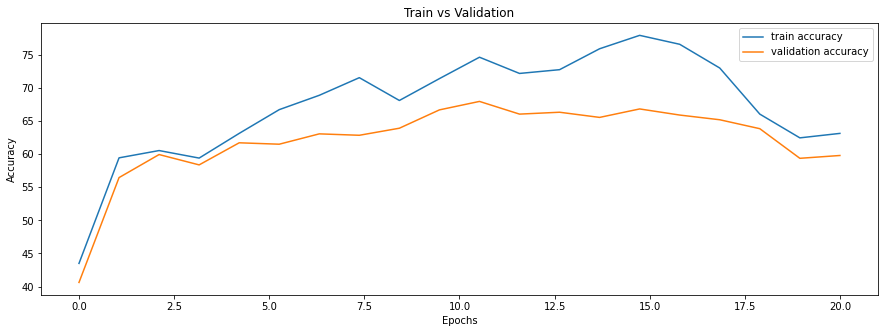

In [ ]:
train_val_comparison_individual(train_accuracy_1, val_accuracy_1, train_loader)

In [ ]:
train_accuracy_1, train_accuracy_2, train_accuracy_3 = accuracyForEachEpoch(resNet_train), accuracyForEachEpoch(denseNet_train), accuracyForEachEpoch(vgg_train)

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, train_accuracy_list_3, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="ResNet50")
    plt.plot(x, train_accuracy_list_2, label="DenseNet121")
    plt.plot(x, train_accuracy_list_3, label="Vgg16")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train Accuracy")
    plt.legend()

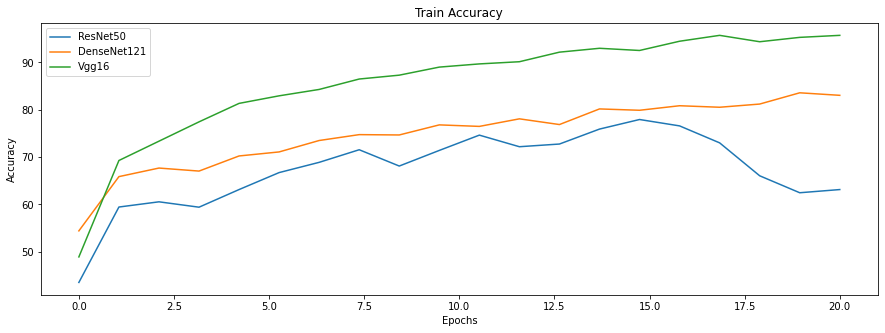

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, train_accuracy_3, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2, val_accuracy_3 = accuracyForEachEpoch(resNet_val), accuracyForEachEpoch(denseNet_val), accuracyForEachEpoch(vgg_val)

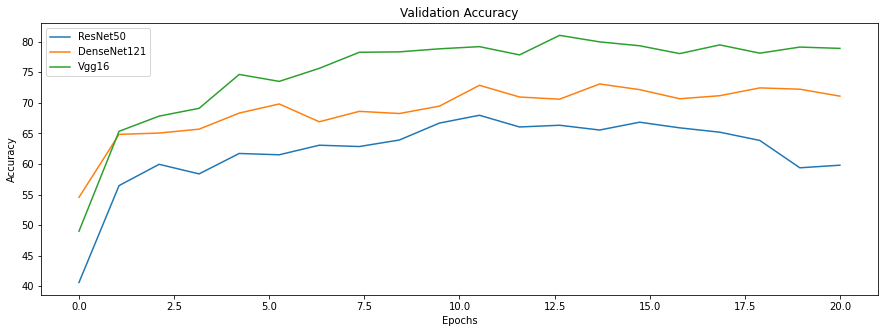

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, val_accuracy_3, len(train_loader))

In [ ]:
def subplot(train_accuracy_list_1,train_accuracy_list_2,train_accuracy_list_3,val_accuracy_list_1,val_accuracy_list_2,val_accuracy_list_3):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)    
    plt.plot(x, train_accuracy_list_1, label="Train accuracy")
    plt.plot(x, val_accuracy_list_1, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("ResNet50")
    plt.legend()
    plt.subplot(1,3,2)    
    plt.plot(x, train_accuracy_list_2, label="Train accuracy")
    plt.plot(x, val_accuracy_list_2, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("DenseNet121")
    plt.legend()
    plt.subplot(1,3,3)    
    plt.plot(x, train_accuracy_list_3, label="Train accuracy")
    plt.plot(x, val_accuracy_list_3, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Vgg16")
    plt.suptitle("Train vs Validation")
    plt.legend()


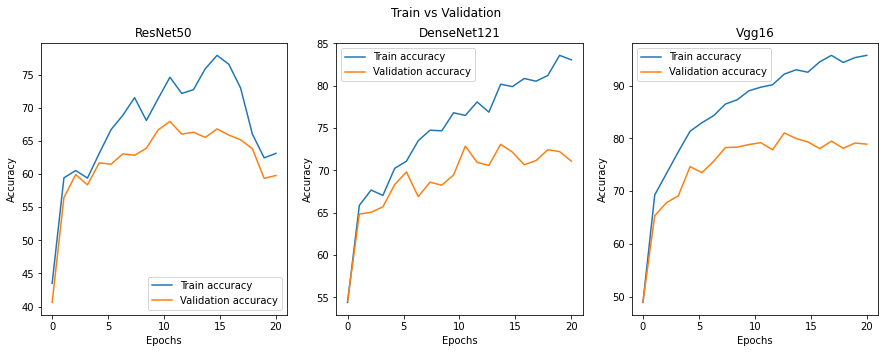

In [ ]:
subplot(train_accuracy_1,train_accuracy_2,train_accuracy_3,val_accuracy_1,val_accuracy_2,val_accuracy_3)

# Dataset-1

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet_tl_23.pth")

In [ ]:
resNet.keys()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/denseNet_23.pth")

In [ ]:
denseNet.keys()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg_23.pth")

In [ ]:
vgg.keys()

In [ ]:
resNet_train, resNet_val = resNet['training_accuracy_list'], resNet['val_accuracy_list']

In [ ]:
denseNet_train, denseNet_val = denseNet['train_accuracy_list'], denseNet['val_accuracy_list']

In [ ]:
vgg_train, vgg_val = vgg['training_accuracy_list'], vgg['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%234==0):
            accuracy.append(sum/234)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy_1, train_accuracy_2, train_accuracy_3 = accuracyForEachEpoch(resNet_train), accuracyForEachEpoch(denseNet_train), accuracyForEachEpoch(vgg_train)

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, train_accuracy_list_3, loader_length):
    x = np.linspace(0, 6, num=6)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="ResNet50")
    plt.plot(x, train_accuracy_list_2, label="DenseNet121")
    plt.plot(x, train_accuracy_list_3, label="Vgg16")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation")
    plt.legend()

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, train_accuracy_3, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2, val_accuracy_3 = accuracyForEachEpoch(resNet_val), accuracyForEachEpoch(denseNet_val), accuracyForEachEpoch(vgg_val)

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, val_accuracy_3, len(train_loader))

In [ ]:

def subplot(train_accuracy_list_1,train_accuracy_list_2,train_accuracy_list_3,val_accuracy_list_1,val_accuracy_list_2,val_accuracy_list_3):
    x = np.linspace(0, 6, num=6)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)    
    plt.plot(x, train_accuracy_list_1, label="Train accuracy")
    plt.plot(x, val_accuracy_list_1, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("ResNet50")
    plt.legend()
    plt.subplot(1,3,2)    
    plt.plot(x, train_accuracy_list_2, label="Train accuracy")
    plt.plot(x, val_accuracy_list_2, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("DenseNet121")
    plt.legend()
    plt.subplot(1,3,3)    
    plt.plot(x, train_accuracy_list_3, label="Train accuracy")
    plt.plot(x, val_accuracy_list_3, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Vgg16")
    plt.suptitle("Train vs Validation")
    plt.legend()


In [ ]:
subplot(train_accuracy_1,train_accuracy_2,train_accuracy_3,val_accuracy_1,val_accuracy_2,val_accuracy_3)

# Transfer Learning

## ResNet50

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet50.pth")

In [ ]:
resNet.keys()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet_tl = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet50_tl.pth")

In [ ]:
resNet_tl.keys()

In [ ]:
resNet_train, resNet_val = resNet['train_accuracy_list'], resNet['val_accuracy_list']

In [ ]:
resNet_tl_train, resNet_tl_val = resNet_tl['train_accuracy_list'], resNet_tl['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%88==0):
            accuracy.append(sum/88)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy_1, train_accuracy_2 = accuracyForEachEpoch(resNet_train), accuracyForEachEpoch(resNet_tl_train)

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="ResNet50")
    plt.plot(x, train_accuracy_list_2, label="ResNet50 with Transfer learning")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2 = accuracyForEachEpoch(resNet_val), accuracyForEachEpoch(resNet_tl_val)

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, len(train_loader))

## DenseNet121

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet.pth")

In [ ]:
denseNet.keys()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet_lr = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet_lr.pth")

In [ ]:

denseNet_lr.keys()

In [ ]:
denseNet_train, denseNet_val = denseNet['training_accuracy_list'], denseNet['val_accuracy_list']

In [ ]:
denseNet_tl_train, denseNet_tl_val = denseNet_lr['training_accuracy_list'], denseNet_lr['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%88==0):
            accuracy.append(sum/88)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy_1, train_accuracy_2 = accuracyForEachEpoch(denseNet_train), accuracyForEachEpoch(denseNet_tl_train)

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="DenseNet121")
    plt.plot(x, train_accuracy_list_2, label="DenseNet121 with Transfer learning")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train Accuracy")
    plt.legend()

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2 = accuracyForEachEpoch(denseNet_val), accuracyForEachEpoch(denseNet_tl_val)

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, len(train_loader))

# Hyper-parameter tuning

## Learning rate

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet.pth")

In [ ]:
denseNet.keys()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet_best = load_checkpoint("/content/drive/MyDrive/AI Final Project/dense_net_bestLR8Class1.pth")

In [ ]:
denseNet_best.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
train_accuracy_1, train_accuracy_2 = accuracyForEachEpoch(denseNet["training_accuracy_list"]), accuracyForEachEpoch(denseNet_best["training_accuracy_list"])

In [ ]:
  def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="lr=0.001")
    plt.plot(x, train_accuracy_list_2, label="lr=000.1")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train Accuracy")
    plt.legend()

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, _)

In [ ]:
val_accuracy_1, val_accuracy_2 = accuracyForEachEpoch(denseNet["val_accuracy_list"]), accuracyForEachEpoch(denseNet_best["val_accuracy_list"])

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, _)